# ДЗ1. Адаптация LLM под задачу

## Введение

Дата выдачи: 08.02.2026

Мягкий дедлайн: 23:59MSK 24.02.2026

Жесткий дедлайн: 23:59MSK 01.03.2026

В этом домашнем задании вам предстоит адаптировать одну и ту же LLM под задачу следования инструкциям и сравнить несколько практических подходов:

* **Prompting (baseline):** без обучения, только подбор формата запроса.
* **LoRA fine-tuning:** параметро-эффективное дообучение (можно в 4-bit режиме).
* **Full fine-tuning:** дообучение целиком (обучаем все веса).
* **DPO:** дообучение по предпочтениям на парных данных (chosen/rejected).

В ходе работы вы пройдёте весь *post-training* пайплайн:

1. Подготовка данных и шаблона диалога (chat template)
2. Prompting baseline и набор фиксированных тест-промптов
3. Реализация LoRA-слоя + тесты
4. Встраивание LoRA в модель + sanity-checks
5. SFT-дообучение: LoRA vs full fine-tuning
6. Сравнение качества/стоимости и анализ ошибок
7. DPO по предпочтениям (chosen/rejected)

> В ноутбуке используется `tokenizer.apply_chat_template` для формирования промптов под instruct-модель.

**О задании**

Вы берете одну модель и ведете ее через этапы адаптации: prompting -> LoRA-SFT -> full-SFT -> DPO, после чего делаете сравнение на фиксированных промптах и на отложенной выборке (loss). На каждом этапе вы сохраняете результаты (ответы на одинаковых промптах и метрики), чтобы сравнение было честным и воспроизводимым.

**Оценивание и условия**

Максимальный балл за работу - **10**.

Вот несколько правил, который помогут нам сделать работу приятнее и продуктивнее:

* Можно использовать любые свободные источники с обязательным указанием ссылки на них. Если в работе вы используете генеративные модели, их указание обязательно. Также следите за оригинальностью: генеративного кода должно быть не более 60% работы. На усмотрение проверяющего баллы за работу в случае использования сгенерированного кода могут быть снижены.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

**Формат сдачи**

Задания сдаются через систему **LMS**. Посылка должна содержать:

- ноутбук homework-01-Username.ipynb
где Username - ваша фамилия латиницей, без пробелов (например, homework-01-Ivanov.ipynb).



## Setting

In [ ]:
# IMPORTANT:
# 1) СНАЧАЛА запустите ноутбук в "CPU-режиме" и проверьте,
#    что базовая часть работает: импорты, загрузка датасета,
#    токенизация, форматирование промпта, 1 короткая генерация.
#
# 2) ТОЛЬКО ПОСЛЕ этого подключайте GPU и грузите модель на CUDA.
#
# Почему так:
# - В Colab подключение GPU начинает "съедать" лимит времени/ресурсов,
#   даже когда вы просто думаете и ничего не считаете.
# - Если сначала отладить код на CPU, вы экономите GPU-время и нервы.
#
# Как подключить GPU:
# Runtime -> Change runtime type -> Hardware accelerator -> GPU

In [ ]:
%pip -q install "transformers>=4.43" "datasets>=2.18" "accelerate>=0.33" "trl>=0.9" "bitsandbytes>=0.45"

import os, random, math, time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    DataCollatorForLanguageModeling
)

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "Qwen/Qwen3-0.6B"

DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
print("device:", device, "| dtype:", DTYPE)

device: cuda | dtype: torch.bfloat16


## Задание 0. Данные и вспомогательные функции (1 балл)

**Данные:** `tatsu-lab/alpaca`

В этом ДЗ мы используем датасет `tatsu-lab/alpaca` - это версия Stanford Alpaca, одного из самых известных учебных наборов для **instruction fine-tuning (SFT)**.

Он содержит пары *инструкция -> ответ* (и иногда дополнительный input) в полях `instruction`, `input`, `output`.

Важно понимать, что это **синтетический** датасет: инструкции и ответы были сгенерированы с помощью модели OpenAI `text-davinci-003`, поэтому данные могут быть неидеальными и местами слишком гладкими/шаблонными - это нормальная часть эксперимента.

**Почему мы работаем именно с ним?**

1. **Простой и понятный формат.** Удобно собрать chat-template и быстро запустить SFT без долгой возни с парсингом диалогов.
2. **Небольшой и быстрый для обучения.** Можно брать небольшой срез (несколько тысяч примеров) и уложиться в разумное время даже на ограниченной GPU.
3. **Хорош для честного сравнения режимов post-training.** На одном и том же наборе легко сравнить: prompting vs LoRA-SFT vs full-SFT - и увидеть trade-off качество/стоимость.
4. **Учебная ценность.** Датасет достаточно разнообразный по типам инструкций (объяснения, списки, преобразования, простые задачи), поэтому эффект от fine-tuning обычно заметен даже при коротком обучении.

### Ознакомиться с данными (0.5 балла)

Перед тем как обучать модель, нужно минимально понять, что именно лежит в датасете и как это будет превращаться в диалог.

**Что нужно сделать:**

1. Загрузить `tatsu-lab/alpaca` и вывести:

   - список колонок,
   - размер датасета,
   - 3 случайных примера (с выводом `instruction`, `input`, `output`).

2. Посчитать и вывести (в одном месте, коротко):

   - долю примеров, где `input` пустой,
   - распределение длины `output` (например, min/median/mean/max по числу символов или токенов - на ваш выбор),
   - топ-5 самых частых первых слов в `instruction`.

3. Вручную посмотреть 5 примеров и ответить текстом:

   - какие типы инструкций встречаются чаще всего?
   - есть ли странные или явно низкокачественные ответы? (2–3 предложения)

4. Разбейте данные на `train_ds_txt` и `test_ds_txt`: 80/20 или 90/10 или 95/5, чтобы быстрее.

> Разбиение данных на train/test фиксируется один раз в начале и используется во всех режимах обучения.

In [ ]:
import random
import numpy as np
import pandas as pd
from collections import Counter

In [ ]:
# !в сплите можно управлять размером данных
ds = load_dataset("tatsu-lab/alpaca", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [ ]:
print("Колонки:", ds.column_names) # список колонок
print("Размер датасета:", len(ds), '\n') # размер датасет

# 3 случайных примера (с выводом instruction, input, output)
for i in range(3):
    idx = random.randint(0, len(ds)-1)
    ex = ds[idx]
    print(f"instruction: {ex['instruction'][:30]}...")
    print(f"input: {ex['input'][:30]}")
    print(f"output: {ex['output'][:30]}...\n")

Колонки: ['instruction', 'input', 'output', 'text']
Размер датасета: 52002 

instruction: What are the advantages of usi...
input: 
output: The advantages of using a Scru...

instruction: Design an advertisement for a ...
input: 
output: Stay secure and monitored with...

instruction: Cite a relevant quote that ref...
input: Message: Never give up on your
output: "Our greatest weakness lies in...



In [ ]:
# Доля примеров, где input пустой
empty_input = sum(1 for ex in ds if ex['input'] == '')
print(f"Доля примеров, где input пустой: {round(empty_input/len(ds), 2)}")

# Распределение длины output
output_lengths = [len(ex['output']) for ex in ds]
print(f"\nРаспределение длины output:")
print(f"min: {min(output_lengths)}")
print(f"median: {np.median(output_lengths)}")
print(f"mean: {np.mean(output_lengths)}")
print(f"max: {max(output_lengths)}")

# Топ-5 самых частых первых слов в instruction
first_words = [ex['instruction'].split()[0] if ex['instruction'].split() else '' for ex in ds]
word_counts = Counter(first_words)
print("\nТоп-5 самых частых первых слов в instruction:")
for word, count in word_counts.most_common(5):
    print(f"{word}: {count}")

Доля примеров, где input пустой: 0.6

Распределение длины output:
min: 0
median: 185.0
mean: 270.31233414099455
max: 4181

Топ-5 самых частых первых слов в instruction:
Generate: 4687
Create: 3795
Describe: 2967
Write: 2758
What: 2271


In [ ]:
# Вручную посмотреть 5 примеров
for i in range(5):
    idx = random.randint(0, len(ds)-1)
    ex = ds[idx]
    print(f"instruction: {ex['instruction'][:80]}...")
    print(f"input: {ex['input'][:50]}")
    print(f"output: {ex['output'][:80]}...\n")

instruction: Generate two similar sounding but semantically different words to contrast this ...
input: Light
output: Bright and Dim....

instruction: Explain the engineering design process....
input: 
output: The engineering design process is an iterative problem-solving approach used to ...

instruction: Give an example of a web service that could be automated using artificial intell...
input: 
output: One example of a web service that could be automated using AI is customer servic...

instruction: Given a block of text, come up with a catchy headline that best represents the t...
input: The new coaching program will help you become a be
output: Lead. Succeed. Transform – A Comprehensive Guide To Reach The Top....

instruction: Edit the text to make the meaning more precise....
input: The President announced an ambitious plan to cut t
output: The President announced an ambitious plan to reduce taxes for all American citiz...



Какие типы инструкций встречаются чаще всего?

`В основном встречаются конструкции повелительного наклонени - "Generate", "Given", "Describe", "Write", "Create", это стандартные служебные фразы при работе c ИИ для того, что получить какую-либо информацию`


Есть ли низкокачественные примеры? (2–3 предложения)

- `instruction: Construct a Regex statement to extract the links from given text....
input: The following page has a list of useful links: www
output: \s(https?://[^\s]+)\s...`

- `instruction: Design a poster about endangered species....
input:
output: [A poster with a picture of an endangered animal, such as a tiger or an elephant...`

- `instruction: Generate an example of personification....
input:
output: The sun smiled down on the bright summer flowers....`


In [ ]:
# Разбейте данные на train_ds_txt и test_ds_txt: 80/20 или 90/10 или 95/5, чтобы быстрее
ds_split = ds.train_test_split(test_size=0.2, seed=SEED)
train_ds_txt = ds_split['train']
test_ds_txt = ds_split['test']

### Вспомогательные функции и базовая загрузка модели (0.5 балла)


Дальше в ДЗ вам будет постоянно нужно:

1. **собирать чат-промпт** из сообщений (user / assistant / system),
2. **быстро генерировать ответы** базовой/дообученной модели,
3. **превращать Alpaca-пример** в готовую строку `text` для SFT (`train_ds_txt/test_ds_txt`).

Чтобы не копировать один и тот же код по всему ноутбуку, мы предлагаем сделать несколько вспомогательных функций.

> **Это не строго обязательно.** Если вам проще - вы можете не писать эти функции и делать всё в лоб прямо в следующих заданиях. Но с функциями будет проще поддерживать код и сравнивать результаты.
>
> Если вы примете решение их не реализовывать, напишите комментарий об этом для проверяющего.

**Шаг 1. Загрузите токенайзер и базовую модель** `Qwen/Qwen3-0.6B` с [HuggingFace](https://huggingface.co/Qwen/Qwen3-0.6B). Проверьте, что модель переводится в `eval()` и умеет генерировать (в следующем шаге).


In [ ]:
MODEL_NAME = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=DTYPE
)
model.eval()

# Возможно, потребуется явно выставить pad_token
print("Tokenizer pad_token:", tokenizer.pad_token, "| eos_token:", tokenizer.eos_token)

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Tokenizer pad_token: <|im_end|> | eos_token: <|im_end|>


**Шаг 2. Подготовьте функции:**

- `make_chat(messages, add_generation_prompt=True)` - собирает строку промпта из списка сообщений.
- `make_user_assistant_pair(...)` - удобный конструктор списка сообщений.
- `generate_text(...)` - генерирует ответ модели на один запрос.
- `alpaca_to_text(ex)` - превращает одну запись Alpaca в поле `{"text": ...}` для обучения.

In [ ]:
# Chat-template

def make_chat(messages, add_generation_prompt: bool = True) -> str:
    """
    Универсальная сборка промпта:
    - если у токенайзера есть chat_template -> используем apply_chat_template
    - иначе -> делаем простой fallback-формат

    messages: list[dict], пример:
      [{"role":"system","content":"..."}, {"role":"user","content":"..."}]
    """
    """Универсальная сборка промпта"""
    try:
        return tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=add_generation_prompt
        )
    except:
        result = ""
        for msg in messages:
            role = msg["role"]
            content = msg["content"]
            if role == "system":
                result += f"System: {content}\n"
            elif role == "user":
                result += f"User: {content}\n"
            elif role == "assistant":
                result += f"Assistant: {content}\n"
        if add_generation_prompt:
            result += "Assistant: "
        return result

In [ ]:
# Удобный конструктор сообщений

def make_user_assistant_pair(
    user_text: str,
    assistant_text: str | None,
    system_text: str | None = None
):
    """
    Собирает список сообщений:
    (опционально) system -> user -> (опционально) assistant
    """
    messages = []
    if system_text:
        messages.append({"role": "system", "content": system_text})
    messages.append({"role": "user", "content": user_text})
    if assistant_text:
        messages.append({"role": "assistant", "content": assistant_text})
    return messages

In [ ]:
# Генерация текста (один промпт в один ответ)

@torch.no_grad()
def generate_text(
    model,
    user_text: str,
    system_text: str | None = None,
    max_new_tokens=128,
    temperature=0.7,
    top_p=0.9
) -> str:

    """
    Генерация ответа модели на один запрос.
    Возвращает decoded строку (без спец-токенов).
    """
    messages = make_user_assistant_pair(user_text, None, system_text)
    prompt = make_chat(messages, add_generation_prompt=True)

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id
    )

    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

In [ ]:
def alpaca_to_text(ex):
    """
    Делает из Alpaca-примера поле text (готовое для SFTTrainer),
    используя make_chat(..., add_generation_prompt=False).

    Alpaca поля:
      ex["instruction"], ex.get("input",""), ex["output"]
    """
    messages = [
        {"role": "user", "content": ex["instruction"] + (("\n" + ex["input"]) if ex["input"] else "")},
        {"role": "assistant", "content": ex["output"]}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False
    )
    return {"text": text}

**Шаг 3. Мини-проверки (sanity-check):**

- напечатайте пример результата `alpaca_to_text` (первые 400–600 символов),
- сгенерируйте ответ базовой модели на простой промпт (1-2 примера),
- убедитесь, что ничего не падает.

In [ ]:
# Проверка: генерация на базовой модели
print(generate_text(model, "Explain what overfitting is in 2 bullet points."))

<think>
Okay, the user wants me to explain overfitting in two bullet points. Let me start by recalling what overfitting means. From what I remember, overfitting is when a model learns the training data too much, right? So, it gets better at the training data but fails on new data. But I need to make sure I explain it clearly.

First bullet point: Overfitting occurs when a model learns the training data too well, leading it to make predictions on new data that are not present in the training set. That makes sense. The second bullet point could mention that this results in poor generalization


In [ ]:
# Проверка: что alpaca_to_text возвращает строку
ex0 = ds[0]
tmp = alpaca_to_text(ex0)
print(type(tmp), list(tmp.keys()))
print(tmp["text"][:600])

<class 'dict'> ['text']
<|im_start|>user
Give three tips for staying healthy.<|im_end|>
<|im_start|>assistant
<think>

</think>

1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.<|im_end|>



## Задание 1. Prompting baseline (0.5 балла)

Прежде чем обучать модель (LoRA / full SFT), нужно получить честный нулевой уровень (*baseline*): как ведёт себя та же самая модель, если мы вообще не трогаем веса и меняем только формат запроса.

Это важно по двум причинам:

1. **Контрольная точка для сравнения.** Если после SFT ответы стали лучше, мы должны понимать: это действительно эффект обучения, или мы могли бы получить почти то же самое простым промптингом.

2. **Проверка стабильности и воспроизводимости.** Фиксированный набор тест-промптов станет вашим мини-бенчмарком, на котором вы потом сравните baseline vs LoRA-SFT vs full-SFT.


Теперь давайте:

1. Соберем фиксированный набор тест-промптов `EVAL_PROMPTS` (минимум 15).
   Промпты должны быть **разнотипными**: объяснение, список, преобразование текста, простой код, вопрос на здравый смысл и т.п.

2. Для каждого промпта получим ответы базовой модели в двух режимах:

* **без system** (обычный user - assistant)
* **с system** (добавляем системную инструкцию, например "кратко, структурно")

3. Сформируем результаты в таблицу `baseline_df` со столбцами:

* `prompt`
* `no_system`
* `with_system`

> Предполагается, что из **Задания 0** у вас уже есть:
>*Курсив*
> `base_model`, `generate_text()` и рабочий токенайзер/модель.


- Использую model вместо base_model

In [ ]:
for i in range(12):
    idx = random.randint(0, len(ds)-1)
    ex = ds[idx]
    print(f"{ex['instruction']}")

Answer this question: "What are the advantages of using AI in healthcare?"
Given a list of elements, find how many possible combinations of the elements can be made.
Assign a category to the given list of words.
Given a sentence, make it more concise while keeping its meaning intact.
Write a 5-sentence story about a dog who wants a special treat.
Find out the capital of Canada. Output the name of the city.
Write a sentence that illustrates the meaning of the word "capricious".
List 5 common bacteria species.
Generate a children's story that includes the character of a friendly lion.
Convert 100 grams to pounds.
Generate a new design for a watch based on the given input.
Explain the concept of descriptive writing.


In [ ]:
# Prompting baseline

EVAL_PROMPTS = [
    "Explain overfitting in 3 bullet points.",
    "Write a Python function that checks if a number is prime.",
    "Give a short summary of the idea of gradient descent.",

    "Give four examples of plant-based proteins.",
    "Make a comparison between two things.",
    "Suggest five fun activities for a virtual team bonding session.",
    "Suggest a diet plan that is both healthy and affordable.",
    "Analyze the given sentence and explain the context in which the sentence could be applicable",
    "Design a system to help manage customer support tickets.",
    "Connect the words in the sentence with a hyphen",
    "Describe a process of cleaning silverware.",
    "Group these words as related topics",
    "Are tarantulas poisonous? Give a detailed answer.",
    "Summarize the differences between a Microsoft Access and Microsoft Excel.",
    "Name five reasons why artificial intelligence is important for businesses."
]

SYSTEM_INSTR = "Отвечай кратко, структурно, без воды. Если уместно — списком."

baseline_rows = []

for p in EVAL_PROMPTS:

    no_system = generate_text(model, p, system_text=None, max_new_tokens=100)
    with_system = generate_text(model, p, system_text=SYSTEM_INSTR, max_new_tokens=100)

    baseline_rows.append({
        "prompt": p,
        "no_system": no_system,
        "with_system": with_system
    })

baseline_df = pd.DataFrame(baseline_rows)

In [ ]:
# your code here: покажите первые строки baseline_df
baseline_df.sample(n=10)

,prompt,no_system,with_system
9,Connect the words in the sentence with a hyphen,"<think>\nOkay, let's see. The user wants me to...","<think>\nOkay, the user wants me to connect wo..."
11,Group these words as related topics,"<think>\nOkay, let's see. The user wants me to...","<think>\nOkay, let's see. The user wants me to..."
0,Explain overfitting in 3 bullet points.,"<think>\nOkay, the user wants me to explain ov...","<think>\nOkay, the user wants an explanation o..."
13,Summarize the differences between a Microsoft ...,"<think>\nOkay, so I need to compare Microsoft ...","<think>\nOkay, the user wants a summary of the..."
5,Suggest five fun activities for a virtual team...,"<think>\nOkay, the user wants five fun activit...","<think>\nOkay, the user wants five fun activit..."
8,Design a system to help manage customer suppor...,"<think>\nOkay, so I need to design a system to...","<think>\nOkay, the user wants to design a syst..."
2,Give a short summary of the idea of gradient d...,"<think>\nOkay, so I need to give a short summa...","<think>\nOkay, the user is asking for a short ..."
1,Write a Python function that checks if a numbe...,"<think>\nOkay, I need to write a Python functi...","<think>\nOkay, I need to write a Python functi..."
14,Name five reasons why artificial intelligence ...,"<think>\nOkay, the user wants five reasons why...","<think>\nOkay, the user is asking for five rea..."
4,Make a comparison between two things.,"<think>\nOkay, the user wants me to make a com...","<think>\nOkay, the user wants me to make a com..."


Напишите коротко текстом:

* В каких типах промптов `SYSTEM_INSTR` реально помогает?

`В более сложные вопросах, например - "Are tarantulas poisonous? Give a detailed answer.", в задачах сравнения - "Summarize the differences between a Microsoft Access and Microsoft Excel."`

* Где почти не влияет?

`Не наблюдаю особых различий в задаче "Group these words as related topics", а также в задаче простейшей сложности - "Make a comparison between two things."`

## Задание 2. Реализация LoRA слоя + тесты (1.5 балла)

В следующих заданиях вы будете дообучать модель с LoRA. Чтобы понимать, что именно меняется в модели и почему LoRA экономит ресурсы, мы сначала реализуем LoRA **вручную** для одного базового кирпичика - `nn.Linear`.

Это дает две вещи:

1. **Понимание механики:** LoRA - это не магия из библиотеки, а конкретная добавка низкорангового обновления к уже обученному слою.
2. **Контроль корректности:** тесты гарантируют, что слой ведет себя правильно (особенно важное свойство `B=0 -> слой = base`).

**Задание:**

Реализуйте LoRA-обертку для `nn.Linear` по формуле:

$$
y = Wx + \frac{\alpha}{r}\cdot (xAB)
$$

Где:

- `W` - **замороженные** веса исходного слоя
- `A` и `B` - **обучаемые** матрицы низкого ранга (`r`)
- при `B = 0` слой должен в точности совпадать с исходным линейным слоем
- градиенты должны идти только в `A` и `B` (веса `W` не обучаются)

In [ ]:
# LoRA layer (исправленная версия)
class LoRALinear(nn.Module):
    def __init__(self, base: nn.Linear, r: int = 8, alpha: float = 16.0, dropout: float = 0.0):
        super().__init__()
        assert isinstance(base, nn.Linear)

        self.base = base
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r
        self.drop = nn.Dropout(dropout)

        # 1) Freeze base weights
        # 2) Create LoRA params A and B
        # 3) Init A (B stays zeros to satisfy B=0 => base)

        for param in self.base.parameters():
            param.requires_grad = False

        dtype = base.weight.dtype
        device = base.weight.device

        self.A = nn.Parameter(torch.randn(base.in_features, r, device=device, dtype=dtype) * 0.01)
        self.B = nn.Parameter(torch.zeros(r, base.out_features, device=device, dtype=dtype))

    def forward(self, x):
        base_out = self.base(x)
        lora_out = (x @ self.A) @ self.B * self.scaling
        return base_out + lora_out

In [ ]:
# Тесты (должны проходить)

def test_lora_basic():
    torch.manual_seed(0)

    lin = nn.Linear(4, 3, bias=False)
    lin.weight.data.fill_(1.0)

    lora = LoRALinear(lin, r=2, alpha=2.0, dropout=0.0)

    x = torch.randn(5, 4)
    y_base = lin(x)
    y_lora = lora(x)

    # Property: B=0 => LoRA equals base layer
    assert torch.allclose(y_base, y_lora, atol=1e-6), "B=0 => LoRA must equal base layer"

    # Gradients should flow into A and B
    loss = y_lora.sum()
    loss.backward()
    assert lora.A.grad is not None and lora.B.grad is not None, "No grads for LoRA params"

test_lora_basic()
print("LoRA tests: OK")

LoRA tests: OK


**Мини-вопрос**

Почему мы инициализируем `B` нулями, а `A` - случайно? Что это даёт в начале обучения?

`Для того, чтобы в начале обучения Lora слой был как базовый слой (B = 0), случайная инициализация А дает стартовые значения`

Справка из лекции:

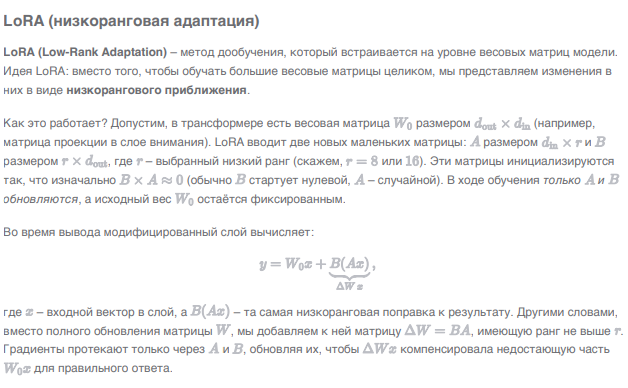

## Задание 3. Встраивание LoRA в модель + sanity-check (1 балл)

Вы уже реализовали LoRA для одного слоя. Теперь нужно сделать следующий инженерный шаг:

1. **встроить LoRA внутрь реальной LLM**, заменив нужные `nn.Linear` слои в attention-блоке,
2. убедиться, что мы действительно обучаем только LoRA-параметры, а не случайно разморозили половину модели.

Это важный sanity-check перед любым обучением: иначе вы можете потратить часы GPU и не понять, *что именно* вы обучали.

**Задание:**

1. Загрузите модель `MODEL_NAME`, если еще нет.
2. Встройте LoRA минимум в слои attention-проекций:

   - обязательно: `q_proj`, `k_proj`, `v_proj`
   - опционально (приветствуется): `o_proj`
3. Посчитайте:

   - число обучаемых параметров
   - долю обучаемых параметров от общего числа
4. Сделайте sanity-check:

   - среди всех параметров с `requires_grad=True` должны быть только LoRA-матрицы `A` и `B`.

> Предполагается, что из Задания 0 у вас уже есть: `MODEL_NAME`, `DTYPE`, а из Задания 2 - класс `LoRALinear`.

In [ ]:
# Inject LoRA into model

from transformers import AutoModelForCausalLM

def set_submodule(root: nn.Module, path: str, new_module: nn.Module):

    """
    Заменяет подмодуль по строковому пути вида "model.layers.0.self_attn.q_proj".
    """

    parts = path.split(".")
    parent = root
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_module)

def inject_lora(
    model: nn.Module,
    target_suffixes=("q_proj","k_proj","v_proj","o_proj"),
    r=8,
    alpha=16,
    dropout=0.05
):

    replaced = 0

    for param in model.parameters():
        param.requires_grad = False

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and any(name.endswith(suf) for suf in target_suffixes):
            lora_module = LoRALinear(module, r=r, alpha=alpha, dropout=dropout)
            set_submodule(model, name, lora_module)
            replaced += 1

    return replaced

In [ ]:
# Load fresh model for LoRA experiment
lora_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=DTYPE
)

# Inject LoRA
num_replaced = inject_lora(lora_model, r=8, alpha=16, dropout=0.05)
print("Replaced линейных слоёв:", num_replaced)

Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Replaced линейных слоёв: 112


In [ ]:
# Count trainable params

trainable = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in lora_model.parameters())
print("Trainable params:", trainable)
print("Total params:", total)
print("Trainable share:", trainable / total)

Trainable params: 2293760
Total params: 753926144
Trainable share: 0.0030424200278164116


In [ ]:
# Sanity-check: only A/B are trainable

bad = []
for n, p in lora_model.named_parameters():
    if p.requires_grad:
        # Логика: если имя не заканчивается на ".A" или ".B" -> добавить в bad
        if not (n.endswith(".A") or n.endswith(".B")):
            bad.append(n)

print("Non-LoRA trainable params:", bad[:20], "count=", len(bad))
assert len(bad) == 0, "Нашлись обучаемые параметры не из LoRA!"
print("sanity-check: OK")

Non-LoRA trainable params: [] count= 0
sanity-check: OK


**Вопрос:**

Почему LoRA обычно ставят именно в `q_proj/k_proj/v_proj` (и иногда `o_proj`)? Что это дает по сравнению с "вставить LoRA куда угодно"?

`Адаптация весов Attention дает наибольший прирост качества при наименьшем количестве обучаемых параметров. Если вставлять Lora куда угодно, то количество обучаемых параметров вырастет и метод будет ресурнозатратным`

Ссылка на сайт с полезной информацией https://arxiv.org/abs/2106.09685

## Задание 4. SFT обучение с LoRA (2 балла)

На baseline-промптинге мы увидели, что можно выжать из модели без обучения. Теперь задача - сделать **instruction fine-tuning (SFT)** и проверить, что:

1. модель действительно обучается (loss убывает),
2. поведение меняется осмысленно на том же наборе `EVAL_PROMPTS` (то есть улучшение - не кажется, а видно при прямом сравнении).

Это ключевой этап: дальше вы будете сравнивать LoRA-SFT с full-SFT, поэтому нужно аккуратно зафиксировать результат LoRA.

**Этапы:**
1. Соберите конфиг обучения SFTConfig.
2. Запустите SFT-обучение LoRA-модели на `train_ds_txt` (поле `text`).
   Можно использовать `trl.SFTTrainer` (рекомендуется) или свой цикл.
3. Покажите, что training loss убывает (достаточно лога `logging_steps` и/или графика).
4. Сравните ответы baseline vs LoRA-SFT на `EVAL_PROMPTS`:

   * используйте тот же `SYSTEM_INSTR`, что в baseline,
   * соберите таблицу `cmp_df` со столбцами:

     * `prompt`
     * `baseline_with_system`
     * `lora_sft`

5. Покажите `cmp_df.head()` и 3–5 примеров до/после текстом или таблицей.



> Предполагается, что из предыдущих заданий у вас уже есть:
> `lora_model`, `tokenizer`, `train_ds_txt`, `test_ds_txt`, `EVAL_PROMPTS`, `baseline_df`, `SYSTEM_INSTR`, `generate_text()`.

**Ограничения на конфиг**

Вы можете выбирать любые значения, но соблюдайте рамки:

* `max_steps`: [100, 400]
* `learning_rate`: в диапазоне [5e-5, 5e-4]
* `per_device_train_batch_size`: 1 или 2
* `gradient_accumulation_steps`: ≥ 4
* `fp16`: включайте, если `DTYPE == torch.float16` (иначе выключайте)
* `save_strategy="no"` (чтобы не плодить артефакты)

**Вопрос на понимание**

Перед запуском обучения ответьте:

* почему вы выбрали именно такой `learning_rate` и `max_steps`?

`learning_rate - 2e-4, max_steps - 150, беру такие значения так как они не самые минимальные и не самые максимальные. Ранее работал со значением 1e-3, поэтому продолжу практиковать. Хочу, чтобы модель не переобучилась. Большие значения могут увеличить время работы кода, поэтому в процессе буду изменять значения`


* что будет, если сделать `learning_rate` слишком большим?

`Шаги будут слишком большим, что может сделать модель нестабильной`

In [ ]:
# LoRA-SFT
from trl import SFTTrainer, SFTConfig

# Prepare model for training
lora_model.config.use_cache = False
lora_model.train()

# Соберите cfg_lora сами
cfg_lora = SFTConfig(
    output_dir="out_lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    max_steps=150,
    logging_steps=25,
    save_strategy="no",
    fp16=(DTYPE == torch.float16),
    dataset_text_field="text",
    remove_unused_columns=False,
)

trainer_lora = SFTTrainer(
    model=lora_model,
    args=cfg_lora,
    train_dataset=train_ds_txt,
    eval_dataset=test_ds_txt,
    processing_class=tokenizer,
)

# your code here: запустите обучение ᕙ(⇀‸↼‶)ᕗ
trainer_lora.train()

lora_model.eval()

# Compare outputs on EVAL_PROMPTS (baseline vs lora_sft)
lora_rows = []

for i, p in enumerate(EVAL_PROMPTS):
    baseline = baseline_df[baseline_df['prompt'] == p]['with_system'].values[0]
    lora_response = generate_text(lora_model, p, system_text=SYSTEM_INSTR, max_new_tokens=150)

    lora_rows.append({
        "prompt": p,
        "baseline_with_system": baseline,
        "lora_sft": lora_response
    })

cmp_df = pd.DataFrame(lora_rows)

cmp_df.head()

Adding EOS to train dataset:   0%|          | 0/41601 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/41601 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/41601 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/10401 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/10401 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/10401 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151645}.


Step,Training Loss
25,1.879456
50,1.384856
75,1.352842
100,1.371244
125,1.336798
150,1.387150


,prompt,baseline_with_system,lora_sft
0,Explain overfitting in 3 bullet points.,"<think>\nOkay, the user wants an explanation o...","<think>\nOkay, the user wants me to explain ov..."
1,Write a Python function that checks if a numbe...,"<think>\nOkay, I need to write a Python functi...","<think>\nOkay, I need to write a Python functi..."
2,Give a short summary of the idea of gradient d...,"<think>\nOkay, the user is asking for a short ...","<think>\nOkay, let's see. The user is asking f..."
3,Give four examples of plant-based proteins.,"<think>\nOkay, the user is asking for four exa...","<think>\nOkay, the user wants four examples of..."
4,Make a comparison between two things.,"<think>\nOkay, the user wants me to make a com...","<think>\nOkay, the user wants me to make a com..."


Выберите 3 промпта из `EVAL_PROMPTS`, где изменение заметнее всего, и коротко ответьте:

1. что стало лучше/хуже после LoRA-SFT?

`Улучшилась структура ответов - лучше`

`В одном из примеров слово lentils повторяется - хуже`


2. есть ли побочные эффекты (например: ответы стали длиннее, более шаблонными, хуже следуют инструкции)?

`В некоторых ответах модель начала повторять одни и те же слова`

## Задание 5. Full fine-tuning (2 балла)

В предыдущем задании вы сделали LoRA-SFT: обучались только низкоранговые матрицы LoRA, а базовые веса модели были заморожены. Теперь ваша задача - сделать full fine-tuning (full-SFT / FFT): дообучить все веса модели целиком на тех же данных и в том же формате.

Это второй ключевой режим post-training в работе: дальше вы будете сравнивать **LoRA-SFT vs full-SFT** по качеству/стабильности/стоимости.

**Этапы**

1. Загрузите чистую базовую модель из `MODEL_NAME` (без LoRA).
2. Соберите конфиг обучения `SFTConfig` в заданных рамках.
3. Запустите SFT-обучение full-модели на `train_ds_txt` (поле `text`).
4. Покажите, что training loss убывает (лог `logging_steps` и/или график).
5. Сравните ответы baseline vs LoRA-SFT vs full-SFT на `EVAL_PROMPTS`:

* используйте тот же `SYSTEM_INSTR`, что и в baseline,
* соберите таблицу `cmp_full_df` со столбцами:

  * `prompt`
  * `baseline_with_system`
  * `lora_sft`
  * `full_sft`

6. Таблица пригодится нам для отчета в задании 6 как "фиксация поведения".


**Рекомендации на конфиг**

Вы можете выбирать любые значения, но лучше соблюдать рамки:

- `max_steps`: [100, 400]
- `learning_rate`: [5e-5, 5e-4]
- `gradient_accumulation_steps`: >= 4
- `fp16`: включайте, если `DTYPE == torch.float16` (иначе выключайте)
- `save_strategy="no"`

> Подсказка: для full-SFT обычно ставят **меньший learning_rate**, чем для LoRA-SFT, потому что обучаются все веса и модель легче сломать большим шагом.

Перед запуском обучения ответьте:

- почему вы выбрали именно такой learning_rate и max_steps для full-SFT?

`# your text here (ಠ.ಠ)`

In [ ]:
# Full-SFT (full fine-tuning)

from trl import SFTTrainer, SFTConfig
from transformers import AutoModelForCausalLM

full_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=DTYPE
)

full_model.config.use_cache = False
full_model.train()

# sanity-check: проверяем, что все параметры разморожены
for p in full_model.parameters():
    p.requires_grad = True

trainable = sum(p.numel() for p in full_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in full_model.parameters())
print("Trainable params:", trainable)
print("Total params:", total)
print("Trainable share:", trainable / total)

Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Trainable params: 751632384
Total params: 751632384
Trainable share: 1.0


In [ ]:
# Собираем cfg_lora

# Подсказка: параметры, которые точно нужны:
# - output_dir
# - per_device_train_batch_size
# - gradient_accumulation_steps
# - learning_rate
# - max_steps
# - logging_steps
# - save_strategy
# - fp16

cfg_full = SFTConfig(
    output_dir="out_full",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=3e-5,
    max_steps=150,
    logging_steps=25,
    save_strategy="no",
    fp16=(DTYPE == torch.float16),
    dataset_text_field="text",
    remove_unused_columns=False,
)

trainer_full = SFTTrainer(
    model=full_model,
    args=cfg_full,
    train_dataset=train_ds_txt,
    eval_dataset=test_ds_txt,
    processing_class=tokenizer,
)

# train
trainer_full.train()

full_model.eval()

full_rows = []

for p in EVAL_PROMPTS:
    baseline = baseline_df[baseline_df['prompt'] == p]['with_system'].values[0]
    lora = cmp_df[cmp_df['prompt'] == p]['lora_sft'].values[0]
    full_response = generate_text(full_model, p, system_text=SYSTEM_INSTR, max_new_tokens=150)

    full_rows.append({
        "prompt": p,
        "baseline_with_system": baseline,
        "lora_sft": lora,
        "full_sft": full_response
    })

cmp_full_df = pd.DataFrame(full_rows)

cmp_full_df.head()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151645}.


Step,Training Loss
25,1.482563
50,1.318556
75,1.323697
100,1.351465
125,1.315951
150,1.370100


,prompt,baseline_with_system,lora_sft,full_sft
0,Explain overfitting in 3 bullet points.,"<think>\nOkay, the user wants an explanation o...","<think>\nOkay, the user wants me to explain ov...","<think>\nOkay, the user wants me to explain ov..."
1,Write a Python function that checks if a numbe...,"<think>\nOkay, I need to write a Python functi...","<think>\nOkay, I need to write a Python functi...","<think>\nOkay, I need to write a Python functi..."
2,Give a short summary of the idea of gradient d...,"<think>\nOkay, the user is asking for a short ...","<think>\nOkay, let's see. The user is asking f...","<think>\nOkay, the user is asking for a short ..."
3,Give four examples of plant-based proteins.,"<think>\nOkay, the user is asking for four exa...","<think>\nOkay, the user wants four examples of...","<think>\nOkay, the user wants four examples of..."
4,Make a comparison between two things.,"<think>\nOkay, the user wants me to make a com...","<think>\nOkay, the user wants me to make a com...","<think>\nOkay, the user wants me to make a com..."


In [ ]:
# Можно сохранить данные, чтобы не потерять
# cmp_full_df.to_csv("compare_baseline_lora_full.csv", index=False)

Выберите 3 промпта из `EVAL_PROMPTS`, где изменение заметнее всего, и ответьте:

1. что стало лучше/хуже после full-SFT относительно baseline?

`Произошло исправление повторений, добавилась дополнительная информация по тексту - лучше`

2. где full-SFT оказался лучше/хуже LoRA-SFT?

`full-SFT дает более качественные ответы лучше , full-SFT требует больше ресурсов - хуже`


3. есть ли побочные эффекты (длина, шаблонность, ухудшение следования инструкции и т.п.)?

`Ответы стали длиннее`

## Задание 6. Сравнение и анализ ошибок (1 балла)

После prompting и двух режимов обучения (LoRA-SFT и full SFT) важно сравнить модели одним и тем же числом, которое не зависит от вкуса проверяющего и не требует оценки глазами.

**Eval loss и perplexity на отложенной выборке** - это простой способ измерить, насколько модель лучше угадывает правильные ответы (в том формате, в котором мы ее обучали).

> Важно: loss не гарантирует, что ответы красивее или полезнее, но это честная метрика качества под ваш SFT-объектив.

**Этапы:**

1. Реализуйте функцию `eval_loss(model, ds, batch_size=4)`:

   * проходит по датасету батчами,
   * токенизирует поле `text`,
   * считает `loss` модели,
   * возвращает среднее значение loss.

2. Посчитайте `base_loss`, `lora_loss`, `full_loss` на `test_ds_txt`.

3. Посчитайте и выведите perplexit для каждой модели: `ppl = exp(loss)`.

In [ ]:
from transformers import DataCollatorForLanguageModeling

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

test_ds_text = test_ds_txt.map(alpaca_to_text)

def eval_loss(model, ds, num_samples=10):
    model.eval()
    losses = []

    for i in range(min(num_samples, len(ds))):
        text = ds[i]['text']

        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            try:
                outputs = model(**inputs, labels=inputs["input_ids"])
                loss = outputs.loss.item()
                losses.append(loss)
            except Exception as e:
                print(f"Пример {i}: ошибка - {e}")

    return np.mean(losses) if losses else float('nan')

base_loss = eval_loss(model, test_ds_text)
lora_loss = eval_loss(lora_model, test_ds_text)
full_loss = eval_loss(full_model, test_ds_text)

print(f"Base model - loss: {base_loss:.4f}, perplexity: {np.exp(base_loss):.2f}")
print(f"LoRA model - loss: {lora_loss:.4f}, perplexity: {np.exp(lora_loss):.2f}")
print(f"Full model - loss: {full_loss:.4f}, perplexity: {np.exp(full_loss):.2f}")

Map:   0%|          | 0/10401 [00:00<?, ? examples/s]

Base model  - loss: 3.1761, perplexity: 23.95
LoRA model  - loss: 2.7948, perplexity: 16.36
Full model  - loss: 2.7383, perplexity: 15.46


Ответьте коротко:

- Почему важно считать loss на test, а не на train?

`Loss на test показывает, насколько хорошо модель обобщает знания на новые данные`


- Почему perplexity - это просто `exp(loss)` (в 1 предложении)?

`Перплексия — это числовая метрика, которая измеряет степень неопределённости языковой модели относительно предсказания следующего слова в последовательности [1]. Отвеяая на вопрос - это экспонента от кросс-энтропии loss, которая показывает неопределенность модели при предсказании следующего токена`


1 - https://dtf.ru/id2687299/4078483-perpleksiya-chto-eto-takoe-i-kak-ona-ispolzuetsya-v-yazykovykh-modelyakh-ii

### 6.2 Анализ ошибок

Ответьте одним-двумя абзацами:

1. На каких типах промптов LoRA дала улучшение сильнее, чем full fine-tuning (если такое есть)?
2. Где full fine-tuning оказался лучше?
3. Видите ли вы признаки переобучения (например: ответы стали слишком шаблонными/слишком длинными/ухудшилась общая адекватность)?
4. Какой метод вы бы выбрали в реальном проекте при ограниченном бюджете GPU - и почему?

**Ответ:**
`1. LoRA давала ответы оптимальной длины, нежели full`

`2. Full SFT исправил проблему повторений, также добавляет больше контекста`

`3. LoRA: повторения слов. Full SFT: ответы стали длиннее и избыточно детальными`

`4. Я бы выбрал LoRA, так как она экономичнее, работает несколько быстрее и выдает соответствующее качество`

## Задание 7. DPO (1 балл)

После SFT (supervised fine-tuning) модель учится копировать "правильные ответы" из датасета (instruction -> answer). Но в реальной жизни часто есть другая постановка: *нам важнее не единственно верный ответ, а предпочитаемый* - например:

* ответ должен быть **более вежливым**,
* **короче / структурнее**,
* **без опасных советов**,
* **более полезным**.

Для этого используют обучение по предпочтениям на парных данных: для одного и того же `prompt` есть два ответа:

* `chosen` - предпочтительный,
* `rejected` - менее предпочтительный.

**DPO (Direct Preference Optimization)** - простой и популярный способ дообучить модель так, чтобы она чаще предпочитала `chosen` и реже - `rejected`, *не вводя отдельную reward-модель и сложный RL-процесс*.

Интуитивно: мы подкручиваем вероятности токенов так, чтобы вероятность `chosen` росла относительно `rejected`.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*lK6iJMz5CGh2fo7TsDn15A.png" alt="drawing" width="700"/>




**Что откуда брать?**

В этом задании нужны 4 вещи:

1. Ваша SFT-модель (желательно `lora_model` после LoRA-SFT из Задания 4) -> это будет `dpo_model`.

2. Reference model (ref_model) - якорь, замороженная копия модели до DPO. -> проще всего: загрузить заново `AutoModelForCausalLM.from_pretrained(MODEL_NAME, ...)`.

   Почему не брать `base_model` из памяти? Можно, но часто он уже жил в ноутбуке, и проще гарантировать чистоту новой загрузкой.

3. Preference-датасет с полями `prompt/chosen/rejected`. -> возьмём `trl-lib/ultrafeedback_binarized` (Hugging Face). Он большой, поэтому берем небольшой срез, например `train[:8000]`.

4. Тренер из TRL: `DPOTrainer` и конфиг `DPOConfig`. -> библиотека `trl` уже ставится у нас в Setting.


**Задание:**

1. Загрузите preference-датасет `trl-lib/ultrafeedback_binarized` и убедитесь, что у него есть (или сделайте через `map`) колонки:

   - `prompt`
   - `chosen`
   - `rejected`

2. Соберите `ref_model` (замороженная копия исходной модели) и `dpo_model` (ваша SFT-модель).

3. Соберите `DPOConfig` самостоятельно (как вы делали в SFT): подберите разумные значения `learning_rate`, `max_steps`, `gradient_accumulation_steps`, `beta`.

4. Запустите DPO-обучение.

5. Покажите 10–15 примеров до/после:

   - до - ответы вашей SFT-модели до DPO (сохраните копию или прогоните заранее),
   - после - ответы `dpo_model` после `trainer_dpo.train()`.

6. Коротко напишите вывод:

   - где стало лучше (в чём именно проявилось предпочтение),
   - где сломалось или стало хуже (типичные failure cases DPO на вашем датасете).

> Важно
>
> * DPO обычно запускают **поверх SFT**, иначе модель может дергаться сильнее.
>
> * Слишком большой `beta` делает обучение агрессивным (модель может стать однообразной).
>
> * Слишком длинный датасет/шаги = долго. Для ДЗ достаточно небольшого числа шагов.


In [ ]:
# Load preference dataset
from trl import DPOTrainer, DPOConfig
from datasets import load_dataset

pref_ds = load_dataset("trl-lib/ultrafeedback_binarized", split="train[:8000]")

# Логика:
# 1) вывести column_names
# 2) если названия отличаются, сделать pref_ds = pref_ds.map(...)
# 3) колонки должны быть строго prompt / chosen / rejected

print("Колонки датасета:", pref_ds.column_names)

def format_to_prompt_chosen_rejected(example):
    prompt = example['chosen'][0]['content']
    chosen = example['chosen'][1]['content']
    rejected = example['rejected'][1]['content']

    return {
        "prompt": prompt,
        "chosen": chosen,
        "rejected": rejected
    }

pref_ds = pref_ds.map(format_to_prompt_chosen_rejected, remove_columns=pref_ds.column_names)

print(pref_ds)
print(pref_ds[0])

README.md:   0%|          | 0.00/643 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/62135 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Колонки датасета: ['chosen', 'rejected', 'score_chosen', 'score_rejected']


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 8000
})
{'chosen': "Sure, I'd be happy to help you write a version of the classic game Snake using the pygame library! Here's a basic outline of how we can approach this:\n\n1. First, we'll need to set up the game display and create a game object that we can use to handle the game's state.\n2. Next, we'll create the game's grid, which will be used to represent the game board. We'll need to define the size of the grid and the spaces within it.\n3. After that, we'll create the snake object, which will be used to represent the player's movement. We'll need to define the size of the snake and the speed at which it moves.\n4. We'll also need to create a food object, which will be used to represent the food that the player must collect to score points. We'll need to define the location of the food and the speed at which it moves.\n5. Once we have these objects set up, we can start handling the game's logic. We'll need to

In [ ]:
# Build ref_model and dpo_model

# ref_model - замороженная копия модели ДО DPO
ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=DTYPE
)
ref_model.eval()
for param in ref_model.parameters():
    param.requires_grad = False

# dpo_model - ваша SFT-модель (LoRA-SFT)
dpo_model = lora_model
dpo_model.train()
dpo_model.config.use_cache = False

# Соберите ref_model и dpo_model
# убедитесь еще, что ref_model НЕ обучается

Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


In [ ]:
# Configure DPO

# your code here: соберите конфиг сами (ง •̀_•́)ง

# Подсказка:
# - max_steps: 100–300 (в зависимости от времени)
# - lr: порядка 1e-6 .. 1e-5
# - beta: 0.05 .. 0.2
# - batch_size обычно 1

cfg_dpo = DPOConfig(
    output_dir="out_dpo",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    learning_rate=1e-6,
    max_steps=50, # уменьшили со 100 до 50
    beta=0.1,
    logging_steps=25,
    save_strategy="no",
    fp16=(DTYPE == torch.float16),
    dataloader_num_workers=2  # параллельная загрузка данных
)


trainer_dpo = DPOTrainer(
    model=dpo_model,
    ref_model=ref_model,
    args=cfg_dpo,
    train_dataset=pref_ds,
    processing_class=tokenizer
)

trainer_dpo.train()

dpo_model.eval()

Extracting prompt in train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

Step,Training Loss
25,0.950937
50,0.888178


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): LoRALinear(
            (base): Linear(in_features=1024, out_features=2048, bias=False)
            (drop): Dropout(p=0, inplace=False)
          )
          (k_proj): LoRALinear(
            (base): Linear(in_features=1024, out_features=1024, bias=False)
            (drop): Dropout(p=0, inplace=False)
          )
          (v_proj): LoRALinear(
            (base): Linear(in_features=1024, out_features=1024, bias=False)
            (drop): Dropout(p=0, inplace=False)
          )
          (o_proj): LoRALinear(
            (base): Linear(in_features=2048, out_features=1024, bias=False)
            (drop): Dropout(p=0, inplace=False)
          )
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
   

TypeError: DPOTrainer.__init__() got an unexpected keyword argument 'tokenizer' - processing_class

In [ ]:
sample_indices = random.sample(range(len(pref_ds)), 10)
sample_indices

[5238, 912, 204, 6074, 2253, 2006, 1828, 1143, 6033, 839]

In [ ]:
# Before/after set

# your code here: выберите 10–15 промптов из pref_ds
DPO_EVAL_PROMPTS = [
    pref_ds[i]['prompt'] for i in sample_indices
]

# your code here: получите ответы "до DPO"
# Подсказка: используйте generate_text(dpo_model, prompt, system_text=SYSTEM_INSTR)
# и сохраните результаты в список
before_rows = []

for i, prompt in enumerate(DPO_EVAL_PROMPTS):
    response = generate_text(lora_model, prompt, system_text=SYSTEM_INSTR, max_new_tokens=128)
    before_rows.append({"prompt": prompt, "response": response})

In [ ]:
# Train DPO

# trainer_dpo = DPOTrainer ... # your code here: ᕙ(⇀‸↼‶)ᕗ

In [ ]:
# After DPO + comparison table

# your code here: получите ответы "после DPO" на тех же DPO_EVAL_PROMPTS
after_rows = []

# your code here: соберите табличку сравнения
# columns: prompt / before / after
# и покажите ее

for i, prompt in enumerate(DPO_EVAL_PROMPTS):
    response = generate_text(dpo_model, prompt, system_text=SYSTEM_INSTR, max_new_tokens=128)
    after_rows.append({"prompt": prompt, "response": response})

In [ ]:
comparison_data = []

for i in range(len(DPO_EVAL_PROMPTS)):
    comparison_data.append({
        "prompt": DPO_EVAL_PROMPTS[i][:50] + "...",
        "before": before_rows[i]["response"][:150] + ("..." if len(before_rows[i]["response"]) > 150 else ""),
        "after": after_rows[i]["response"][:150] + ("..." if len(after_rows[i]["response"]) > 150 else "")
    })

dpo_comparison_df = pd.DataFrame(comparison_data)
dpo_comparison_df

,prompt,before,after
0,so the only way would be to access the operato...,"<think>\nOkay, the user is asking if there's a...","<think>\nOkay, the user is asking about changi..."
1,As the team leader responsible for collaborati...,"<think>\nOkay, the user wants me to summarize ...","<think>\nOkay, let's see. The user wants me to..."
2,"In this task, you are given a string with uniq...","<think>\nOkay, let's see. The input is ""UMkdjI...","<think>\nOkay, let's see. The user wants me to..."
3,"In this task, you're given the title of a five...","<think>\nOkay, let's see. The user provided a ...","<think>\nOkay, so the user wants me to figure ..."
4,Determine the quickest way to get from point A...,"<think>\nOkay, the user wants to know the quic...","<think>\nOkay, let's tackle this query. The us..."
5,how can I generate a jwt assertion in java for...,"<think>\nOkay, the user wants to generate a JW...","<think>\nOkay, the user wants to generate a JW..."
6,"Given a context passage, generate a question f...","<think>\nOkay, let's tackle this query. The us...","<think>\nOkay, the user wants me to generate a..."
7,How can we identify passive voice sentences fr...,"<think>\nOkay, let's see. The user wants to id...","<think>\nOkay, let's see. The user wants to id..."
8,How did the Civil War impact the economic deve...,"<think>\nOkay, the user is asking how the Civi...","<think>\nOkay, let's see. The user is asking h..."
9,"Given the Question and Answer pair, detect whe...","<think>\nOkay, the user is asking for an answe...","<think>\nOkay, let's break this down. The user..."


In [ ]:
dpo_comparison_df.to_csv("dpo_before_after.csv", index=False)

Вместо итога по DPO:
Напишите несколько предложений:
- где стало лучше и почему
- где стало хуже/ломается
- что бы поменяли в конфиге (beta/steps/lr), чтобы улучшить

`Ответы стали более дружелюбными и более структурированными, но наблюдается шаблонность в ответах, где-то избыточная длинна. Можно попробовать поиграться с параметрами`

Сделайте DPO поверх вашей SFT-модели (**рекомендуется начинать с LoRA-SFT**).

Нужно:

1. Загрузить preference-датасет (prompt/chosen/rejected) ([Hugging Face][2])
2. Запустить DPO-обучение
3. Показать **10–15 примеров “до/после”** и короткий вывод: стало ли лучше и где ломается

In [ ]:
from trl import DPOTrainer, DPOConfig

# Пример preference-датасета (можно заменить на другой)
pref_ds = load_dataset("trl-lib/ultrafeedback_binarized", split="train[:8000]")

# your code here: проверьте колонки pref_ds и при необходимости сделайте map
# нужно получить колонки: prompt / chosen / rejected
# (╯°□°）╯︵ ┻━┻

pref_ds

In [ ]:
# ref_model — "референс", обычно замороженная копия модели ДО DPO
ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=DTYPE
)
ref_model.eval()

# dpo_model — ваша SFT-модель (обычно LoRA-SFT удобнее)
dpo_model = lora_model
dpo_model.train()
dpo_model.config.use_cache = False

cfg_dpo = DPOConfig(
    output_dir="out_dpo",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    learning_rate=5e-6,
    max_steps=200,
    beta=0.1,
    logging_steps=25,
    save_strategy="no",
    fp16=(DTYPE == torch.float16)
)

trainer_dpo = DPOTrainer(
    model=dpo_model,
    ref_model=ref_model,
    args=cfg_dpo,
    train_dataset=pref_ds,
    tokenizer=tokenizer,
)

# your code here: trainer_dpo.train() ᕙ(⇀‸↼‶)ᕗ

In [ ]:
# your code here:

# 1) выберите 10–15 промптов (можно из pref_ds)
# 2) покажите "до DPO" (используйте LoRA-SFT модель до обучения или baseline)
# 3) покажите "после DPO" (dpo_model)
# 4) сохраните таблицу dpo_before_after.csv

# (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧

Реализовал выше

## Заключение

Вы попробовали 4 подхода к адаптации одной LLM:

- Prompting baseline (без обучения)
- LoRA-SFT (parameter-efficient)
- Full fine-tuning (все веса)
- DPO (предпочтения)

**Вопрос:** Какой метод показал лучшее соотношение **качество / сложность / время / требования к ресурсам**?
Если бы вы делали продакшн-систему для автоматических ответов ассистента в компании (ограниченный GPU-бюджет), что бы вы выбрали и почему?

`Из всех подходов я бы выбрал LoRA-SFT, так как в ней хорошо сохраняется баланс качества/ресурсов`

а ещё здесь ваши общие впечатления о домашней работе 🙏🏻

`Мне показалась работа интересной, но сложной. Я затратил на работу много времени, делал около 4-ех дней. Также непросто были с ресурсами, так как код работал долго и приходилось ждать`

`В рамках работы, для консультаций, были использованы ИИ помощники, такие как - Grok, DeepSeek`

`Часть работы была проверена на уникальность:`


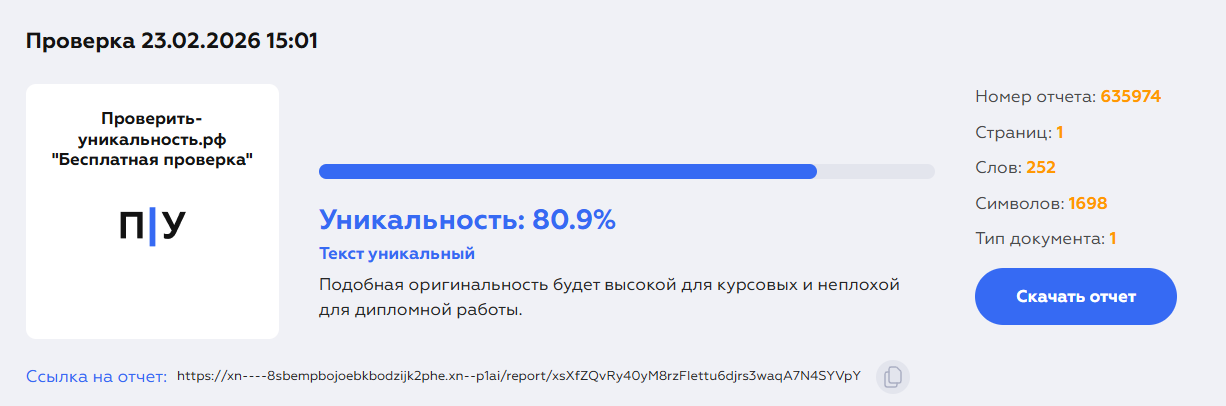![image.png](
)